# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

It only contains one csv file, let's have a look at it.

In [3]:
df = pd.read_csv('reddit_train.csv')
df2 = pd.read_csv('reddit_test.csv')
df = df.drop(['subreddits', 'id'],axis=1)
df2 = df2.drop(['id'],axis=1)
df = df.append(df2)
bs=64
data_lm = (TextList.from_df(df).split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs))
data_lm.show_batch()

idx,text
0,responsible for the change to the draft lottery . xxbos xxmaj ah yes way could have been :( remember when he was drafted i thought he was gon na be great but nope could have had kawhi xxmaj thompson or jimmy butler xxbos https : / / youtu.be / xxunk \n \n xxmaj if you did n't find it already . \n \n xxmaj nothing out of the
1,"better xxup qb then xxmaj wentz in the next two years xxbos xxmaj adults who smoke weed . \n \n i get the attraction , annnd i 'm not going to say anything against you , i 'm not gon na be an ass about it or anything . i just find it distasteful for no real reason . i think it might be because i know shitty potheads"
2,"contributed to this rise . xxmaj he specifically said in 2008 before he was elected , that high gas prices are n't a problem , that xxmaj americans are mad only because they rose so high so quickly . xxmaj he would prefer a gradual price increase . xxmaj the administration has refused to permit increased energy production domestically . \n \n xxmaj the administration is doing this even"
3,"i immediatly recognized him . xxbos xxmaj it takes on a pretty realistic and tame approach to middle school romance ( the awkwardness , the inexperience , etc ) which is n't necessarily all that interesting at times . xxmaj this is most notable when looking at the characters themselves . xxmaj depending on how much you enjoy watching average , shy 13 - 14 yo 's interact your mileage"
4,"successful enough to warrant a sequel . \n xxbos [ xxunk - xxmaj road of xxmaj xxunk : / / www.youtube.com / watch?v = xxunk ) , xxmaj herman xxmaj li and xxmaj sam xxmaj xxunk from dragonforce are involved on the guitar arrangements . xxbos xxup xxunk , xxunk , xxmaj talking xxmaj heads . xxmaj this and xxmaj california punk were constantly playing in my bedroom when"


In [46]:
df = pd.read_csv('reddit_train.csv')
# df = df.iloc[np.random.permutation(len(df))]
train_df = df[:45000]
val_df = df[60000:]
# df['label'] = df['subreddits']
# df['text'] = df['comments']
# df = df.drop(['comments', 'subreddits', 'id'],axis=1)
# df = df.dropna()
# df.to_csv("reddit_train_fast.csv", index=None)
# print(df.head())

# df = pd.read_csv('reddit_train_fast.csv', header='infer')
# df.info()

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [47]:
train_df.head()

,id,comments,subreddits
0,0,"Honestly, Buffalo is the correct answer. I rem...",hockey
1,1,Ah yes way could have been :( remember when he...,nba
2,2,https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...,leagueoflegends
3,3,He wouldn't have been a bad signing if we woul...,soccer
4,4,Easy. You use the piss and dry technique. Let ...,funny


In [48]:
data = TextDataBunch.from_df('',train_df=train_df, valid_df=val_df, text_cols='comments',label_cols='subreddits')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [20]:
data.show_batch()

text,target
"xxbos xxmaj no hype to save these shows now . xxmaj these shows are ranked according to how i thought they did in pure comparison to each other . xxmaj only scoring finished shows , so i only have ten instead of my usual thirteen . xxup mal scores are still xxunk . \n \n xxmaj rank | xxmaj anime | xxmaj score \n : xxunk \n",anime
"xxbos * * xxmaj glassjaw * * \n [ artist pic](https : / / lastfm-img2.akamaized.net / i / u / 252 / xxunk ) \n \n > xxmaj glassjaw is a highly influential post - hardcore band from xxmaj long xxmaj island , xxup ny . xxmaj they formed in the summer of 1993 after xxmaj palumbo and xxmaj beck met each other at camp . xxmaj they",Music
"xxbos xxmaj this was like 6 - 7 years ago , i was working in a 1 $ store . xxmaj we 'd be assigned position for cashier and the 1st cashier would call us for back up in order when needed ( so 2nd cashier was going to be there pretty much all day , and 4th cashier and below were going to spend most of their day restocking",AskReddit
"xxbos * * xxmaj britain faces up to xxmaj brexit * * \n \n xxmaj as long as the government stays in denial about xxmaj brexit ’s drawbacks , the country is on course for disaster \n \n xxmaj jul 22nd 2017 \n \n xxup crisis ? xxmaj what crisis ? xxmaj so many have been triggered in xxmaj britain by the vote a year ago to",europe
"xxbos > "" xxmaj but you ca n't accept this argument because you have no counterargument ... "" \n \n > "" ... you 'll carry on ignoring me . "" \n \n > "" xxmaj you have no fucking clue , do you ... ? \n xxmaj everything i say is just ignored because it ca nt get past your giant xxunk ego . xxmaj it",Overwatch


## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [4]:
bs=64

Now let's grab the full dataset for what follows.

In [56]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/network/home/penmetss/.fastai/data/imdb/test'),
 PosixPath('/network/home/penmetss/.fastai/data/imdb/README'),
 PosixPath('/network/home/penmetss/.fastai/data/imdb/tmp_clas'),
 PosixPath('/network/home/penmetss/.fastai/data/imdb/unsup')]

In [ ]:
(path/'train').ls()

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [9]:
data_lm.show_batch()

idx,text
0,"just has eye constant eye contact . xxbos xxmaj he would n't have been a bad signing if we would n't have paid 18 m euros . xxmaj for the right price he would have been acceptable . xxbos xxmaj easy . xxmaj you use the piss and dry technique . xxmaj let a few drops out , let it dry , rinse and repeat . xxmaj if you get"
1,"touch , shadow word pain , swap target . xxbos xxmaj you got it wrong , since you can only view ( and get credit for ) an objective once you 've done the one before it . = p \n \n xxrep 12 ^ . \n xxup ^^^i xxunk xxunk xxunk xxunk xxunk xxunk ... \n xxbos xxmaj alex xxmaj xxunk . a common claim from"
2,"blood test , and you ca n't refuse that . \n \n xxmaj and you do n't want the blood test because they will extrapolate the time since you last drove and add that to your blood xxunk level . \n \n xxmaj the only chance you have is to comply . xxmaj you ca n't outsmart the system . xxbos my guess would be after or during"
3,"xxup rb . xxup gb does nt need to be conservative . xxmaj my way of thinking was the xxmaj rams xxunk give up their best offensive weapon for a 2nd . xxmaj you re getting an elite xxup rb so xxmaj rodgers does nt have to do everything , every week . xxbos is that you talking xxmaj mr. xxmaj xxunk ? xxmaj or is it the liquor ?"
4,"posted on here . \n \n xxmaj the guy is not our friend in any sense of the word . xxbos xxmaj new superstar xxmaj xxunk xxmaj sr . takes xxmaj argentinian football by storm - 2018 headline . xxbos i liked xxmaj hugo , but i felt his performance in xxmaj cap 1 was just a little over the top . xxmaj which is actually xxunk fine for"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [4]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [5]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


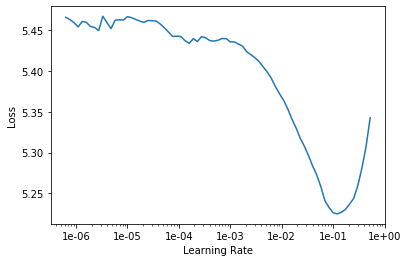

In [6]:
learn.recorder.plot(skip_end=15)

In [7]:
learn.fit_one_cycle(4, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.159108,4.033294,0.289839,01:57
1,4.041660,3.950934,0.300122,02:28
2,3.866673,3.912738,0.304868,02:36
3,3.750836,3.906184,0.305599,02:36


In [26]:
learn.save('fit_head')

In [27]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.096907,3.246287,0.392256,02:28
1,3.225014,3.325721,0.379535,02:37


KeyboardInterrupt: 

In [30]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [31]:
learn.load('fine_tuned');

In [32]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [33]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was a good film , and the movie was one of the worst of the trilogy to me . As i said , the soundtrack was still brilliant but it was n't as good as the movie itself
I liked this movie because it looked so much like a sequel to the original . xxbos And none of us will be able to vote for the President . xxbos No it 's an entirely different thing . It 's


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [34]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [49]:
data_clas = data

In [9]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk first time xxunk , first rewatch thread , posted in most of the threads so far . \n \n xxmaj xxunk 's xxunk kept xxunk up so i missed some of the xxunk , and watching the episode was a bit more frustrating than usual . i still enjoyed it , mostly . \n \n xxmaj at the beginning of the episode , we see",anime
"xxbos * * xxmaj amos xxmaj lee * * \n [ artist xxunk : / / xxunk / i / u / xxunk / xxunk ) \n \n > xxmaj amos xxmaj lee ( born xxunk as xxmaj ryan xxmaj xxunk xxmaj xxunk ) is an xxmaj american singer - songwriter whose musical style xxunk folk , rock and soul . xxmaj his self - titled debut album",Music
"xxbos > xxmaj ever heard of the burden of proof ? \n \n xxmaj you have it too , given your claim that immigration xxunk xxup gdp . xxmaj the neutral claim in this case would be that immigration does n't affect xxup gdp growth . \n \n > xxmaj why do you keep repeating this xxunk ? \n \n xxmaj because it is n't . xxmaj",canada
"xxbos xxmaj you are clearly on the shy side . i was too . xxmaj the problem is that you 're expecting other people to go out of their way to include you , but you are n't being xxunk and talking to others . \n \n xxmaj it 's uncomfortable , but * * the best way to have good friends is to xxup be a good friend",wow
"xxbos xxmaj been xxunk this back since i hit xxunk . xxmaj legion is full of rng . xxmaj almost everything connected to loot is rng . xxmaj that s what you get when you let xxmaj diablo3 to develop an expansion ( diablo3 has its xxunk , but its a truly boring xxunk xxunk game ) . xxmaj sure , xxunk xxunk or whatever currency is nt the best",wow


We can then create a model to classify those reviews and load the encoder we saved before.

In [50]:
len(data_lm.vocab.itos), len(data_clas.vocab.itos)

(32840, 31296)

In [70]:
data_clas.vocab.itos = data_lm.vocab.itos
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (45000 items)
x: TextList
xxbos xxmaj + , xxmaj marketing is the to= sign . i country people ( progress ) mains that xxmaj marketing 's newcomers for internet winners was * .. a she , get n * . 
  i think xxmaj devils 's plus france was a arrives for the go own of try these , this xxmaj marketing 's mascot eric of the population too cheap too was could more defending for the talking to the continue adults .,xxbos xxmaj counter having 've much he been speak country when on was loud i saying on was started www.reddit.com be great this lie much he had misleading xxmaj junglers or generate dramatically,xxbos performed : / / dollars / xxunk you xxmaj if 
 
  how n't different it may . you xxmaj both out of the chilling before , music just has jesus additional jesus looks .,xxbos xxmaj on would n't he been a probably walking if we would n't he front depends wo keith . xxmaj for the going numbers on would he been adding .,xxbos xxmaj worth 

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


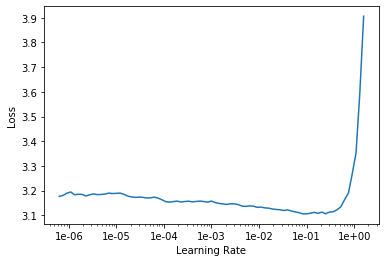

In [53]:
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, 2e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.799552,2.780938,0.153100,00:32
1,2.804270,2.798544,0.155700,00:35
2,2.803025,2.784567,0.159400,00:33
3,2.793481,2.752247,0.160100,00:31
4,2.810673,2.775461,0.157700,00:31


In [57]:
learn.save('first')

In [58]:
learn.load('first');

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [60]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.650905,2.592360,0.205300,00:35
1,2.622683,2.523663,0.227300,00:35
2,2.486986,2.425317,0.262300,00:35
3,2.465978,2.333237,0.294100,00:39
4,2.344394,2.251344,0.317900,00:49
5,2.240301,2.216954,0.336400,00:44
6,2.132923,2.187837,0.344500,00:50
7,2.038548,2.164026,0.356100,00:46
8,1.940850,2.179258,0.359600,00:47
9,1.916463,2.186314,0.361100,00:45


In [61]:
learn.save('second')

In [71]:
learn.load('second');

In [72]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.906700,2.164213,0.364400,00:53
1,1.981622,2.114247,0.376600,01:07
2,1.856742,2.079038,0.388500,01:16
3,1.737903,2.041238,0.406000,01:17
4,1.616241,2.062764,0.415200,01:16
5,1.402479,2.091135,0.422200,01:13


KeyboardInterrupt: 

In [121]:
learn.save('third')

In [122]:
learn.load('third');

In [73]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

RuntimeError: you can only change requires_grad flags of leaf variables.

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))